In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

# darkgrid, whitegrid, dark, white, ticks
# talk, paper, notebook, poster
sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

df = pd.read_csv('data/Fish.csv')
X = df[['Length1', 'Length2', 'Length3', 'Height', 'Width']]
y = df['Weight']

print('Dataset Shape:{}'.format(df.shape), '\n')
print(df.head(), '\n')
print(df.info(), '\n')
print(df.isnull().sum())


Dataset Shape:(158, 6) 

   Weight  Length1  Length2  Length3   Height   Width
0   242.0     23.2     25.4     30.0  11.5200  4.0200
1   290.0     24.0     26.3     31.2  12.4800  4.3056
2   340.0     23.9     26.5     31.1  12.3778  4.6961
3   363.0     26.3     29.0     33.5  12.7300  4.4555
4   430.0     26.5     29.0     34.0  12.4440  5.1340 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Weight   158 non-null    float64
 1   Length1  158 non-null    float64
 2   Length2  158 non-null    float64
 3   Length3  158 non-null    float64
 4   Height   158 non-null    float64
 5   Width    158 non-null    float64
dtypes: float64(6)
memory usage: 7.5 KB
None 

Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


In [2]:
# Part a
def press_statistic(y_true, y_pred, X):
    """
    Calculation of the `Press Statistics <https://www.otexts.org/1580>`_
    """
    res = y_pred - y_true
    hat = X.dot(np.linalg.pinv(X))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res / den)
    return sqr.sum()


def predicted_r2(y_true, y_pred, X):
    """
    Calculation of the `Predicted R-squared <https://rpubs.com/RatherBit/102428>`_
    """
    press = press_statistic(y_true=y_true, y_pred=y_pred, X=X)
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - press / sst


def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse = np.square(y_pred - y_true).sum()
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - sse/sst


def prep(X, deg=1):
    X = X.copy()
    for i in range(X.shape[1]):
        X[:, i] = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    intercept = np.ones((X.shape[0], 1))
    X_new = np.c_[intercept, X]
    for i in range(X.shape[1]):
        for d in range(2, deg + 1):
            X_new = np.c_[X_new, X[:, i] ** d]
    return X_new


def h(x, w):
    return x.dot(w)


def mse(x, y, w):
    m = len(y)
    p = h(x, w)
    err = np.sum((p - y) ** 2) / 2 / m
    return err


def RegressionTrainerGD(X, y, learning_rate=0.01, iteration=1000, l2=0, prepr=True):
    if prepr:
        X = prep(X)
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    e = [0] * iteration
    for it in range(iteration):
        g = X.T.dot(h(X, w) - y) + 2 * l2 * np.sum(w)
        w = w - learning_rate * g
        e[it] = mse(X, y, w)
    return w, e


def RegressionTrainerNQ(X, y, prepr=True):
    if prepr:
        X = prep(X)
    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return w


def eval(X, y, deg=1, display=True, learning_rate=1e-3, iteration=5000):
    X = prep(X.values, deg)
    y = y.values
    r = {}

    w, e = RegressionTrainerGD(
        X, y, learning_rate=learning_rate, iteration=iteration, prepr=False)
    y_pred = h(X, w)
    r2_err = r2(y, y_pred)
    pr2_err = predicted_r2(y, y_pred, X)
    r['GD'] = [r2_err, pr2_err]
    if display:
        print('Gradient Descent')
        print(f'R-Squared: {r2_err:.4f}')
        print(f'R-Squared Prediction: {pr2_err:.4f}')
        print()

    w = RegressionTrainerNQ(X, y, prepr=False)
    y_pred = h(X, w)
    r2_err = r2(y, y_pred)
    pr2_err = predicted_r2(y, y_pred, X)
    r['NQ'] = [r2_err, pr2_err]
    if display:
        print('Normal Equation')
        print(f'R-Squared: {r2_err:.4f}')
        print(f'R-Squared Prediction: {pr2_err:.4f}')
        print()

    if not display:
        return r


eval(X, y)


Gradient Descent
R-Squared: 0.8849
R-Squared Prediction: 0.8690

Normal Equation
R-Squared: 0.8855
R-Squared Prediction: 0.8694



In [3]:
# Part b
from itertools import chain, combinations
from tabulate import tabulate


def powerset(s):
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))


def checkall(X, y, deg=1):
    psf = powerset(X.columns)
    header = ['Feature Set', 'GD RS', 'GD RSP', 'NE RS', 'NE RSP']
    rows = []
    for fs in psf:
        fs = list(fs)
        r = eval(X[fs], y, deg, False)
        rows.append([fs, r['GD'][0], r['GD'][1], r['NQ'][0], r['NQ'][1]])
    rows = sorted(rows, key=lambda x: x[4], reverse=True)
    rows = [header] + rows
    table = tabulate(rows, headers='firstrow',
                     tablefmt='fancy_grid', floatfmt='.4f')
    print(table, end='\n\n')

    with open('P4_b.csv', 'w', encoding='utf-8') as f:
        for r in rows:
            f.write(','.join(map(lambda x: str(x).replace(',', ''), r)))
            f.write('\n')


checkall(X, y)


╒══════════════════════════════════════════════════════╤═════════╤══════════╤═════════╤══════════╕
│ Feature Set                                          │   GD RS │   GD RSP │   NE RS │   NE RSP │
╞══════════════════════════════════════════════════════╪═════════╪══════════╪═════════╪══════════╡
│ ['Length1', 'Length3', 'Height']                     │  0.8842 │   0.8721 │  0.8845 │   0.8722 │
├──────────────────────────────────────────────────────┼─────────┼──────────┼─────────┼──────────┤
│ ['Length1', 'Length2', 'Length3', 'Height']          │  0.8842 │   0.8709 │  0.8845 │   0.8710 │
├──────────────────────────────────────────────────────┼─────────┼──────────┼─────────┼──────────┤
│ ['Length2', 'Length3', 'Height']                     │  0.8822 │   0.8705 │  0.8826 │   0.8708 │
├──────────────────────────────────────────────────────┼─────────┼──────────┼─────────┼──────────┤
│ ['Length1', 'Length3', 'Height', 'Width']            │  0.8850 │   0.8703 │  0.8854 │   0.8707 │
├─────────

In [4]:
# Part c
from scipy.stats import t


def pvalues(X, y):
    X = prep(X)
    m = X.shape[0]
    n = X.shape[1]
    w = RegressionTrainerNQ(X, y, prepr=False)
    y_pred = h(X, w)
    sigma_hat = np.sqrt(np.sum(np.square(y - y_pred)) / (m - n))
    cov = np.linalg.inv(X.T @ X)
    t_vals = w / (sigma_hat * np.sqrt(np.diagonal(cov)))
    p_vals = t.sf(np.abs(t_vals), m - n) * 2
    return p_vals


def backward_reg(X, y, thr_out=0.15):
    included = list(X.columns)
    while True:
        changed = False
        pvals = pvalues(X[included].values, y.values)[1:]
        worst_pval = pvals.max()
        if worst_pval > thr_out:
            changed = True
            worst_feature = pvals.argmax()
            del included[worst_feature]
        if not changed:
            break
    return included


print('Best selected features using Backward Regression:')
print(backward_reg(X, y, thr_out=0.15))


Best selected features using Backward Regression:
['Length1', 'Length3', 'Height']


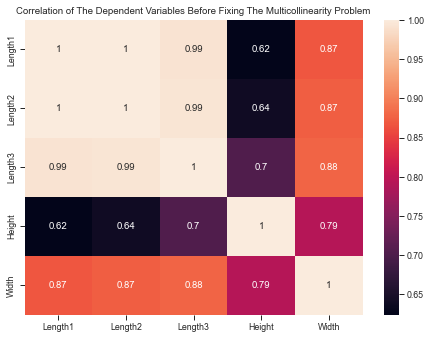

In [5]:
# Part d
sns.heatmap(X.corr(), annot=True)
plt.title(
    'Correlation of The Dependent Variables Before Fixing The Multicollinearity Problem')
plt.savefig('P4_d.png')
plt.show()


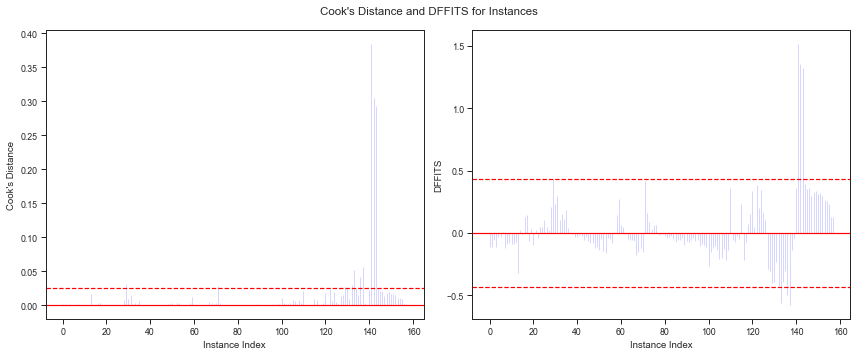

In [6]:
# Part e
def cook_distance(X, y):
    d = np.zeros(X.shape[0])
    X = prep(X)
    w = RegressionTrainerNQ(X, y, False)
    y_pred = h(X, w)
    thr = 4 / X.shape[0]
    for i in range(X.shape[0]):
        X_ = np.delete(X, i, 0)
        y_ = np.delete(y, i)
        w_ = RegressionTrainerNQ(X_, y_, False)
        y_pred_ = h(X, w_)
        sse = np.square(y_pred - y_pred_).sum()
        mse = np.square(y_pred_ - y).sum() / len(y)
        d[i] = sse / (len(w) * mse)
    return d, thr


def dffits(X, y):
    d = np.zeros(X.shape[0])
    X = prep(X)
    w = RegressionTrainerNQ(X, y, False)
    H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
    y_pred = h(X, w)
    thr = 2 * np.sqrt((len(w) + 1) / (len(y) - len(w) - 1))
    for i in range(X.shape[0]):
        X_ = np.delete(X, i, 0)
        y_ = np.delete(y, i)
        w_ = RegressionTrainerNQ(X_, y_, False)
        y_pred_ = h(X, w_)
        se = y_pred[i] - y_pred_[i]
        mse = np.square(y_pred_ - y).sum() / len(y)
        d[i] = se / np.sqrt(mse * H[i, i])
    return d, thr


def cook_plot(X, y, ax):
    cd, thr = cook_distance(X.values, y.values)
    for i in range(len(cd)):
        sns.lineplot(x=[i, i], y=[0, cd[i]], color='blue', ax=ax)
    ax.axhline(thr, color='red', ls='--',)
    ax.axhline(0, color='red')
    ax.set(xlabel='Instance Index', ylabel="Cook's Distance")


def dffits_plot(X, y, ax):
    cd, thr = dffits(X.values, y.values)
    for i in range(len(cd)):
        sns.lineplot(x=[i, i], y=[0, cd[i]], color='blue', ax=ax)
    ax.axhline(thr, color='red', ls='--')
    ax.axhline(-thr, color='red', ls='--')
    ax.axhline(0, color='red')
    ax.set(xlabel='Instance Index', ylabel="DFFITS")


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cook_plot(X, y, ax[0])
dffits_plot(X, y, ax[1])
fig.suptitle("Cook's Distance and DFFITS for Instances")
fig.savefig('P4_e.png')
plt.show()


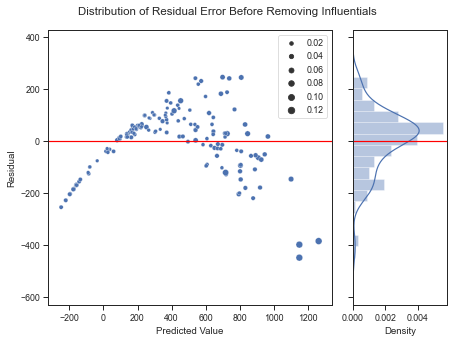

In [7]:
# Part f1
def re_plot(X, y):
    y = y.values
    X = prep(X.values)
    w = RegressionTrainerNQ(X, y, False)
    y_pred = h(X, w)
    H = np.diag(X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T))
    re = y_pred - y
    fig, ax = plt.subplots(1, 2, sharey=True, gridspec_kw={
                           'width_ratios': [3, 1]})
    sns.scatterplot(x=y_pred, y=re, size=H, ax=ax[0])
    sns.distplot(x=re, vertical=True, ax=ax[1])
    ax[0].axhline(0, color='red')
    ax[1].axhline(0, color='red')
    ax[0].set(xlabel='Predicted Value', ylabel='Residual')
    return fig


fig = re_plot(X, y)
fig.suptitle(f'Distribution of Residual Error Before Removing Influentials')
fig.savefig('P4_f1.png')
plt.show()


Performance of the models, after removing 13 Influentials:

Gradient Descent
R-Squared: 0.9142
R-Squared Prediction: 0.9049

Normal Equation
R-Squared: 0.9168
R-Squared Prediction: 0.9075



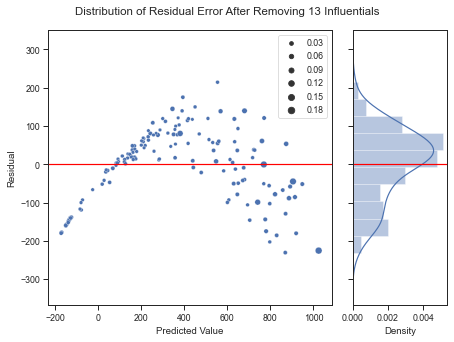

In [8]:
# Part f2
def remove_influentials(X, y, method='or'):
    cd, cthr = cook_distance(X.values, y.values)
    dd, dthr = dffits(X.values, y.values)
    cds = (cd > cthr)
    dds = (dd > dthr) | (dd < -dthr)
    if method == 'or':
        influentials = cds | dds
    elif method == 'and':
        influentials = cds & dds
    elif method == 'cook':
        influentials = cds
    elif method == 'dffits':
        influentials = dds
    X_ = X[~influentials]
    y_ = y[~influentials]
    return X_, y_


X_, y_ = remove_influentials(X, y, 'or')
print(
    f'Performance of the models, after removing {len(y) - len(y_)} Influentials:\n')
eval(X_, y_)

fig = re_plot(X_, y_)
fig.suptitle(
    f'Distribution of Residual Error After Removing {len(y) - len(y_)} Influentials')
fig.savefig('P4_f2.png')
plt.show()


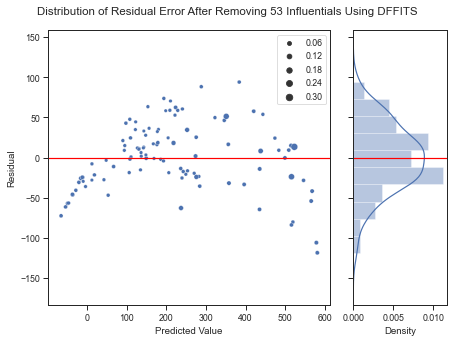

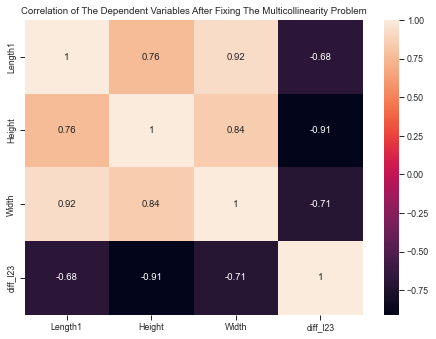

Gradient Descent
R-Squared: 0.9926
R-Squared Prediction: 0.9909

Normal Equation
R-Squared: 0.9926
R-Squared Prediction: 0.9909



In [9]:
# Part g
X_, y_ = remove_influentials(X, y, 'dffits')
for i in range(8):
    X_, y_ = remove_influentials(X_, y_, 'dffits')

fig = re_plot(X_, y_)
fig.suptitle(
    f'Distribution of Residual Error After Removing {len(y) - len(y_)} Influentials Using DFFITS')
fig.savefig('P4_g1.png')
plt.show()

X_['diff_l23'] = X_['Length2'] - X_['Length3']
sns.heatmap(X_.drop(['Length2', 'Length3'], axis=1).corr(), annot=True)
plt.title(
    'Correlation of The Dependent Variables After Fixing The Multicollinearity Problem')
plt.savefig('P4_g2.png')
plt.show()

eval(X_[['Length1', 'Height', 'Width', 'diff_l23']],
     y_, 2, iteration=1100, learning_rate=1e-3)
